In [ ]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

automates the splitting and visualization of image datasets for machine learning tasks using Google Colab. First, it mounts Google Drive and installs the split-folders library to partition data. Images from the specified input folder are split into training, validation, and testing datasets in an 80:10:10 ratio. A function visualize_samples is provided to display random images from the split datasets, showcasing their distribution across classes. It uses matplotlib for visualization, selecting random images from the specified folders. Finally, the script visualizes samples from the training, validation, and testing datasets to confirm the split and content organization.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Copying files: 1938 files [00:20, 96.82 files/s] 


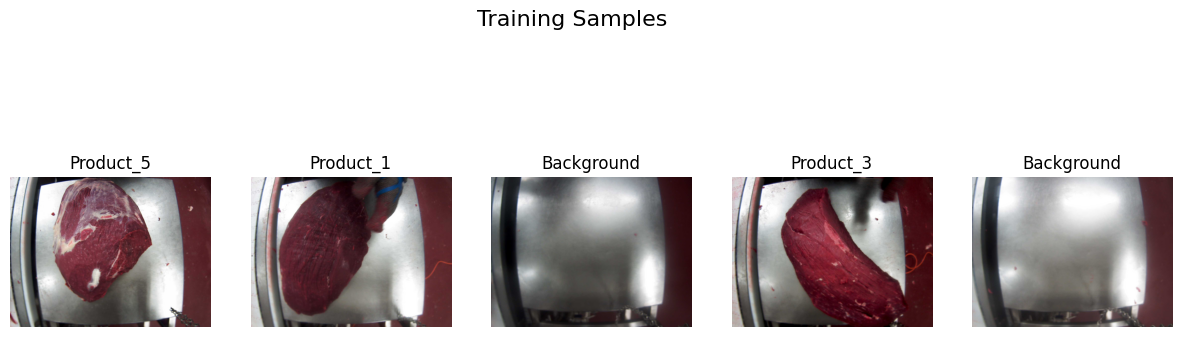

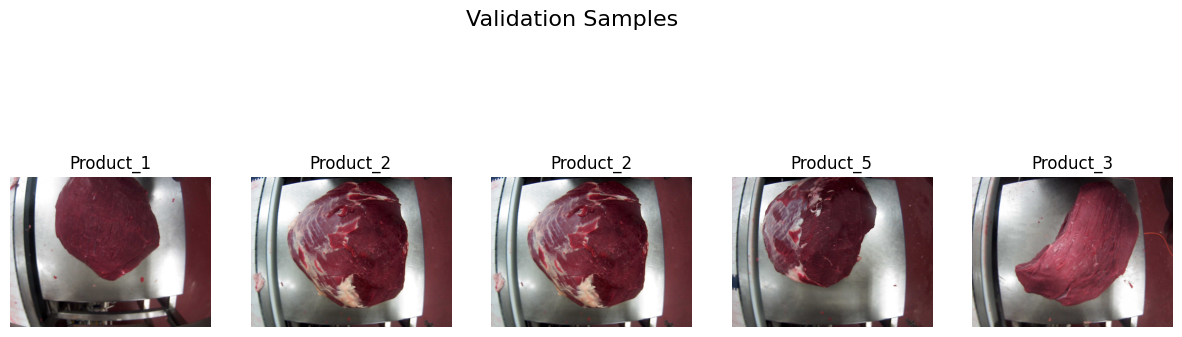

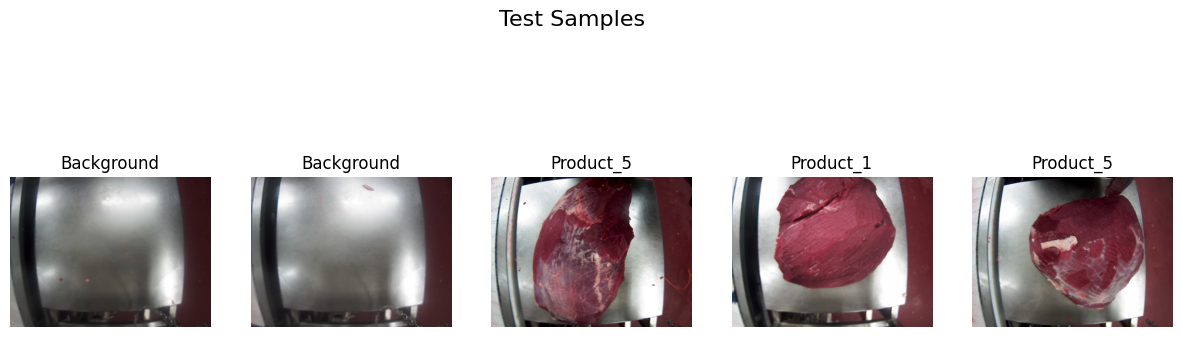

In [ ]:
from google.colab import drive
import matplotlib.pyplot as plt
import os
drive.mount('/content/drive')
# Install the splitfolders library
!pip install split-folders

import splitfolders

# Input folder where the 5 classes are located
input_folder = "/content/drive/MyDrive/MLPR Images-20241219T100019Z-001/MLPR Images"

# Output folder for train/val/test splits
output_folder = "/content/split_data"

# Split the data (80% train, 10% validation, 10% test)
splitfolders.ratio(input_folder,
                   output=output_folder,
                   seed=42,
                   ratio=(0.8, 0.1, 0.1),
                   group_prefix=None)

# Function to visualize samples from a dataset
def visualize_samples(folder, title, num_samples=5):
    """
    Visualize random samples from the specified dataset folder.
    :param folder: Path to dataset folder (e.g., train, val, test)
    :param title: Title for the plot
    :param num_samples: Number of images to visualize
    """
    class_folders = [os.path.join(folder, cls) for cls in os.listdir(folder)]
    class_folders = [f for f in class_folders if os.path.isdir(f)]

    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        # Pick a random class
        selected_class = random.choice(class_folders)
        # Pick a random image from the selected class
        img_path = os.path.join(selected_class, random.choice(os.listdir(selected_class)))
        img = Image.open(img_path)

        # Plot the image
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(os.path.basename(selected_class))

    plt.suptitle(title, fontsize=16)
    plt.show()

# Visualize samples from train, val, and test datasets
visualize_samples(os.path.join("/content/split_data", "train"), "Training Samples")
visualize_samples(os.path.join("/content/split_data", "val"), "Validation Samples")
visualize_samples(os.path.join("/content/split_data", "test"), "Test Samples")

sets up training, validation, and test datasets for a deep learning model using TensorFlow's image_dataset_from_directory. It loads images from the specified directories, resizes them to 150x150, and uses one-hot encoding for the labels. The training and validation datasets are shuffled for randomization, while the test dataset remains unshuffled to preserve order. Each dataset is batched with a size of 32. The class names are printed to confirm the dataset structure, and a sample batch's shape is verified to ensure correct loading and preprocessing of images and labels.

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

# Directories for train, test, and validation sets
train_dir = '/content/split_data/train'
val_dir = '/content/split_data/val'
test_dir = '/content/split_data/test'

# Load the training dataset
train_dataset = image_dataset_from_directory(
    train_dir,
    label_mode='categorical',  # For one-hot encoded labels
    batch_size=32,             # Batch size for training
    image_size=(150, 150),     # Resize images to 150x150
    shuffle=True               # Shuffle the dataset
)

# Load the validation dataset
val_dataset = image_dataset_from_directory(
    val_dir,
    label_mode='categorical',
    batch_size=32,
    image_size=(150, 150)
)

# Load the test dataset
test_dataset = image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    batch_size=32,
    image_size=(150, 150),
    shuffle=False  # Do not shuffle test data
)

# Check the class names
class_names = train_dataset.class_names
print(f"Classes: {class_names}")

# Verify the shapes of the data
for images, labels in train_dataset.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")


Found 1550 files belonging to 6 classes.
Found 192 files belonging to 6 classes.
Found 196 files belonging to 6 classes.
Classes: ['Background', 'Product_1', 'Product_2', 'Product_3', 'Product_4', 'Product_5']
Image batch shape: (32, 150, 150, 3)
Label batch shape: (32, 6)


calculates class weights to address class imbalance in the training dataset. It uses sklearn.utils.class_weight.compute_class_weight for this purpose. First, all labels from the train_dataset are unbatched and flattened into a list of class indices. Then, the class weights are computed based on the frequency of each class, using the balanced strategy to assign higher weights to underrepresented classes. The result is stored in a dictionary, where each class index maps to its respective weight, and it is printed for reference. These weights can be passed to the training process to improve model performance on imbalanced datasets.

In [ ]:
# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Flatten all labels
all_labels = []
for _, labels in train_dataset.unbatch():
    all_labels.append(tf.argmax(labels).numpy())

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced', classes=np.unique(all_labels), y=all_labels
)
class_weights = dict(enumerate(class_weights))
print(f"Class Weights: {class_weights}")


Class Weights: {0: 8.333333333333334, 1: 0.6458333333333334, 2: 23.484848484848484, 3: 0.8072916666666666, 4: 0.8387445887445888, 5: 0.5381944444444444}


develops a CNN for image classification using TensorFlow's Keras API. The model comprises three convolutional layers with ReLU activation, each followed by max-pooling to reduce spatial dimensions, and concludes with a flattening layer, a dense hidden layer, and a softmax output layer for multi-class classification. It is compiled with the Adam optimizer, categorical cross-entropy loss, and accuracy as a metric. The training process uses the training dataset, validates on the test dataset, and incorporates class weights to address class imbalance. Finally, the model's performance is evaluated on the validation dataset to assess its generalization capabilities.

In [ ]:
from tensorflow.keras import layers, models

# Build the CNN model
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile the model
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
cnn_history = cnn_model.fit(
    train_dataset, validation_data=test_dataset, epochs=10, class_weight=class_weights
)

# Evaluate the model
cnn_model.evaluate(val_dataset)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.3960 - loss: 39.8434 - val_accuracy: 0.5000 - val_loss: 1.4301
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.5886 - loss: 1.0083 - val_accuracy: 0.5714 - val_loss: 1.1535
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.6494 - loss: 0.8531 - val_accuracy: 0.2245 - val_loss: 1.7435
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.4986 - loss: 1.5477 - val_accuracy: 0.2908 - val_loss: 4.3878
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.5160 - loss: 1.2471 - val_accuracy: 0.6582 - val_loss: 0.9401
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.7911 - loss: 0.4731 - val_accuracy: 0.6684 - val_loss: 0.8954
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.7886 - loss: 0.4033 - val_accuracy: 0.8163 - val_loss: 0.6232
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9034 - loss: 0.1879 - val_accuracy: 0.8469 - val

[0.3195488452911377, 0.8958333134651184]

implements transfer learning by utilizing the pre-trained ResNet50 model as a feature extractor and adding custom classification layers. The ResNet50 model is loaded with pre-trained ImageNet weights, excluding the top classification layer, and its layers are frozen to prevent further training. A custom dense layer with ReLU activation is added, followed by a dropout layer for regularization, and an output layer with softmax activation for multi-class classification. The model is compiled with the Adam optimizer, categorical cross-entropy loss, and accuracy as the evaluation metric. It is then trained for 10 epochs using the training dataset, with validation on the test dataset, while class weights are applied to handle class imbalance.

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Model

# Load pre-trained ResNet50 model without the top layer
base_model = ResNet50(
    include_top=False, weights='imagenet', input_shape=(150, 150, 3), pooling='avg'
)

# Freeze the base layers
base_model.trainable = False

# Add custom classification layers
x = layers.Dense(128, activation='relu')(base_model.output)
x = layers.Dropout(0.5)(x)
output = layers.Dense(len(class_names), activation='softmax')(x)

# Create the final model
transfer_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
transfer_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
transfer_history = transfer_model.fit(
    train_dataset, validation_data=test_dataset, epochs=10, class_weight=class_weights
)




94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.6025 - loss: 1.6684 - val_accuracy: 0.6224 - val_loss: 0.9666
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - accuracy: 0.7506 - loss: 0.6424 - val_accuracy: 0.8673 - val_loss: 0.3232
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.8363 - loss: 0.3774 - val_accuracy: 0.7959 - val_loss: 0.4187
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 174s 4s/step - accuracy: 0.8646 - loss: 0.2760 - val_accuracy: 0.9337 - val_loss: 0.1951
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - accuracy: 0.8740 - loss: 0.2781 - val_accuracy: 0.8469 - val_loss: 0.3524
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - accuracy: 0.8314 - loss: 0.2476 - val_accuracy: 0.7194 - val_loss: 0.4915
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - accuracy: 0.8469 - loss: 0.2618 - val_accuracy: 0.9388 - val_loss: 0.1758
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - accurac

evaluates the performance of the fine-tuned transfer learning model on the validation dataset. After the fine-tuning process, it uses the evaluate method to compute the accuracy and loss of the model based on the validation data. The results, which include the fine-tuned model's accuracy and loss, are printed, allowing for a comparison with the previous evaluation of the non-fine-tuned transfer model. This helps assess the impact of fine-tuning on model performance and determine if the fine-tuning improved the model's ability to generalize to new data.

In [ ]:
import pandas as pd

# Evaluate both models
loss_cnn,accu_cnn = cnn_model.evaluate(val_dataset)
transfer_loss,transfer_accu = transfer_model.evaluate(val_dataset)


print(" CNN Accuracy and loss: ",loss_cnn,accu_cnn)

print(" transfer Accuracy and loss: ",transfer_loss,transfer_accu)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 470ms/step - accuracy: 0.8685 - loss: 0.4191
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.9737 - loss: 0.0728
 CNN Accuracy and loss:  0.3195488750934601 0.8958333134651184
 transfer Accuracy and loss:  0.07180879265069962 0.9739583134651184


fine-tunes the transfer learning model by unfreezing some of the top layers of the pre-trained ResNet50 base model. Initially, all layers are frozen, and then the last 50 layers are made trainable to allow the model to adapt more specifically to the new dataset. The model is recompiled with a lower learning rate (1e-5) to make gradual updates to the weights during fine-tuning, avoiding large changes that could disrupt the learned features from the pre-trained model. The model is then trained for 5 epochs using the training dataset, with validation on the validation dataset, and class weights are applied to address class imbalance. This process helps the model better adjust to the specific task while retaining useful features from the pre-trained network.

In [ ]:
from tensorflow.keras import optimizers

# Step 5: Fine-tune the model
# Unfreeze some top layers of the base model
base_model.trainable = True

# Optional: Freeze the bottom layers by specifying the number of layers to keep frozen
for layer in base_model.layers[:-50]:  # Freeze all but the last 50 layers
    layer.trainable = False

# Re-compile the model with a smaller learning rate
transfer_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Step 6: Fine-tune the model
fine_tune_history = transfer_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,  # Fewer epochs for fine-tuning
    class_weight=class_weights
)


Epoch 1/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 327s 6s/step - accuracy: 0.9132 - loss: 0.3528 - val_accuracy: 0.9583 - val_loss: 0.0883
Epoch 2/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 321s 6s/step - accuracy: 0.9327 - loss: 0.1617 - val_accuracy: 0.9688 - val_loss: 0.0905
Epoch 3/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 303s 6s/step - accuracy: 0.9510 - loss: 0.1276 - val_accuracy: 0.9740 - val_loss: 0.0866
Epoch 4/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 323s 6s/step - accuracy: 0.9681 - loss: 0.0903 - val_accuracy: 0.9740 - val_loss: 0.0803
Epoch 5/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 304s 6s/step - accuracy: 0.9730 - loss: 0.0744 - val_accuracy: 0.9740 - val_loss: 0.0718


evaluates the fine-tuned transfer learning model on the validation dataset after the fine-tuning process. It uses the evaluate method to compute both the loss and accuracy of the model, allowing us to assess how well the model performs on unseen data after the fine-tuning. The results, including the fine-tuned model's accuracy and loss, are then printed for comparison.

In [ ]:
# Evaluate tuned models

finetune_loss,finetune_acc = transfer_model.evaluate(val_dataset)

print("Finetune Accuracy and loss: ",finetune_acc,finetune_loss)

6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.9862 - loss: 0.0506
Finetune Accuracy and loss:  0.9739583134651184 0.07180879265069962


visualizes the training and validation accuracy, as well as the training and validation loss, for the CNN model over multiple epochs. It plots the accuracy on the left subplot, showing how well the model is performing on both the training and validation sets, helping to identify potential overfitting or underfitting. The right subplot tracks the loss, providing insights into how the model's error is changing during training. The plots are arranged neatly using plt.tight_layout(), and the results of the accuracy and loss are displayed for both training and validation sets. However, there is an error in the code where accu_cnn and loss_cnn are undefined, so they need to be replaced with cnn_history.history['accuracy'] and cnn_history.history['loss'] to correctly print the results.

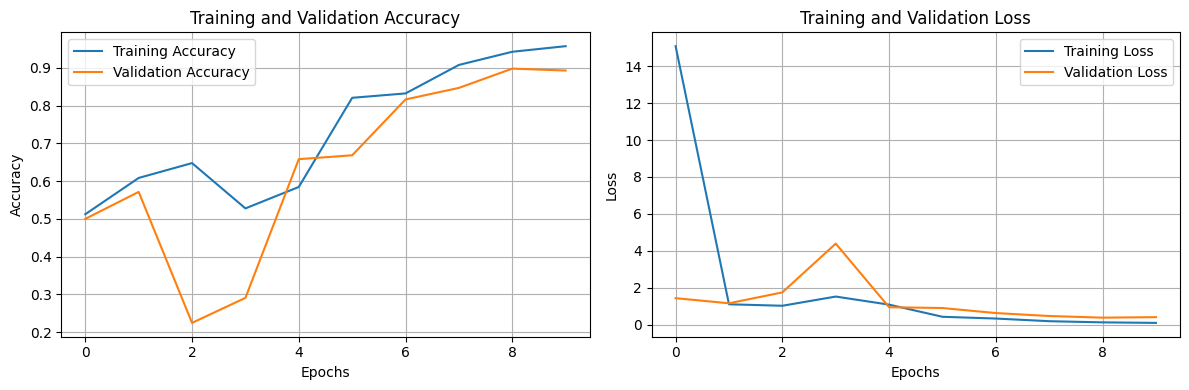

 CNN Accuracy and loss:  0.8958333134651184 0.3195488750934601


In [ ]:

# Plot Training and Validation Accuracy for CNN
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
print(" CNN Accuracy and loss: ",accu_cnn,loss_cnn)


visualizes the training and validation accuracy, as well as the training and validation loss, for the transfer learning model after fine-tuning. It plots the training and validation accuracy on the left subplot, showing the model's performance during both training and evaluation phases. The right subplot displays the training and validation loss, helping to monitor the model's error progression during fine-tuning. plt.tight_layout() is used to arrange the plots neatly, ensuring there is no overlap, and plt.show() displays the plots. Finally, the fine-tuned model's accuracy and loss are printed to show the evaluation results, providing insights into the effectiveness of the fine-tuning process.

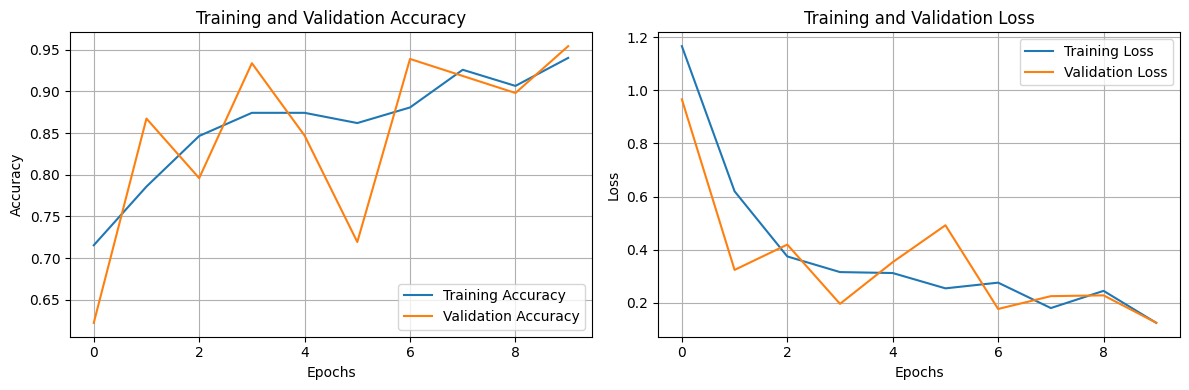

Finetune Accuracy and loss:  0.9739583134651184 0.07180879265069962


In [ ]:
# Plot Training and Validation Accuracy for tuning
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(transfer_history.history['accuracy'], label='Training Accuracy')
plt.plot(transfer_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(transfer_history.history['loss'], label='Training Loss')
plt.plot(transfer_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
print("Finetune Accuracy and loss: ",finetune_acc,finetune_loss)
